# Intro  

Following a meeting with elhanan 03/05 i adjust the basic signal notebook accordingly.
1. Moved some simple routines to .py files in the pycharm project.
2. Adding LOOCV implementation
3. Test different aspects of imputations.
4. Measure correlations between each prediction and observed (On top of existing measurement of RMSE).
5. Expand the tests into high/low training sets


In [1]:
import preprocess_tools
import data_profiling_tools

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn
from copy import deepcopy
import random
from importlib import reload
VERBOSE = True

In [24]:

path = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019'
data_path = path + '/RAW_DATA'
out_path =  path + '/PARSED_DATA/basic_process_reduce_sparse'
pd.options.display.max_rows = 100


## Efrat's Readme

Paper: Franzosa, E. A., Sirota-Madi, A., Avila-Pacheco, J., Fornelos, N., Haiser, H. J., Reinker, S., ... & Sauk, J. S. (2019). Gut microbiome structure and metabolic activity in inflammatory bowel disease. Nature microbiology, 4(2), 293.‏
Link: https://www.nature.com/articles/s41564-018-0306-4?WT.feed_name=subjects_virology  

#======================================================================

Samples info: 220, human gut (IBD + Control)

Excel tables taken from study supplementary.

Species abundance xlsx file also includes the following metadata:
	- Age
	- Diagnosis
	- Fecal.Calprotectin
...& drugs intake data:
	- Antibiotic
	- Immunosuppressant
	- Mesalamine
	- Steroids

Raw data (sequences + raw untargeted metabolomics) available with accession numbers:
- Metabolomics Workbench: PR000677
- SRA with BioProject PRJNA400072

For downloading all FASTQ files (0.6 TB), you can also use the bash script: sra_bash_script_for_fastq_download.sh 
(generated by SRA interactive explorer)
SRA-related metadata on each sample can be found in sra_run_table.txt file (also provides the mapping between subject ID's in xlsx files & SRA sample ID's).



# Read the data


The original sequences pre-processed can be found at : https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001204.v1.p1 (should be found but currently arent there)

In [4]:
stgn_raw = pd.read_excel(f'{data_path}/41564_2018_306_MOESM6_ESM.xlsx', engine='openpyxl', header=1)
stgn_raw.shape
N_sxs = stgn_raw.shape[0]-8


In [5]:
# Create a subset of the 16s data that only contains counts, genus and sample ids
stgn_raw_data = stgn_raw.iloc[8:,].T
stgn_raw_data.columns = stgn_raw_data.iloc[0,:]
stgn_raw_data.drop(['# Feature / Sample'], axis = 0, inplace=True)
stgn_raw_data.columns.name = '# Sample / Feature'
print(f'Shape of shotgun species data: {stgn_raw_data.shape}')
stgn_raw_data.head()

Shape of shotgun species data: (220, 201)


# Sample / Feature,Methanobrevibacter_smithii,Methanosphaera_stadtmanae,Rothia_mucilaginosa,Propionibacterium_freudenreichii,Bifidobacterium_adolescentis,Bifidobacterium_animalis,Bifidobacterium_bifidum,Bifidobacterium_breve,Bifidobacterium_catenulatum,Bifidobacterium_dentium,...,Klebsiella_unclassified,Proteus_mirabilis,Haemophilus_parainfluenzae,Akkermansia_muciniphila,Methanobrevibacter_unclassified,Collinsella_stercoris,Bacteroides_clarus,Bacteroides_plebeius,Lactobacillus_delbrueckii,Lactobacillus_sakei
PRISM|7122,0,0,0,0,0.000092,0,0,0,0,0,...,0,0,0.000006,0.004785,0,0,0,0,0,0
PRISM|7147,0.000019,0,0.000009,0,0.000015,0.000002,0.000008,0,0,0,...,0.000034,0,0.000027,0.000033,0,0,0,0,0,0
PRISM|7150,0,0,0,0.001754,0.040328,0.000019,0.00003,0.000004,0.000176,0,...,0,0,0,0.02458,0,0,0,0,0,0
PRISM|7153,0,0,0,0,0.000056,0,0,0,0,0,...,0,0,0.000016,0.000073,0,0,0,0,0,0
PRISM|7184,0,0,0,0,0.000026,0,0,0,0,0,...,0,0,0.000027,0.00213,0,0,0,0,0,0


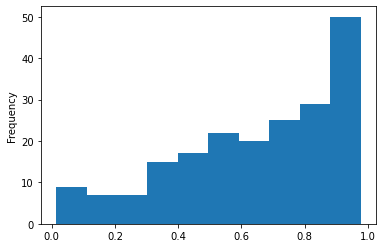

In [6]:
zeros_per_feature = data_profiling_tools.get_spartsity_plot(stgn_raw_data)

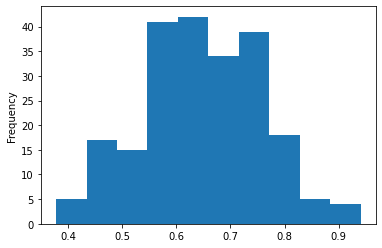

In [7]:
zeros_per_sample = data_profiling_tools.get_spartsity_plot(stgn_raw_data, 1)

**Most samples have 55-75% zeros.**  
**In terms of species many of them are higly sparase, this is partly due to this being a comprehension of three different datasets**

## Separate Metadata

In [8]:
# Extract 8 first rows of metadata
metadata = stgn_raw.iloc[0:8,:]
metadata

,# Feature / Sample,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,...,Validation|UMCGIBD00588,Validation|UMCGIBD00106,Validation|UMCGIBD00393,Validation|UMCGIBD00458,Validation|UMCGIBD00254,Validation|UMCGIBD00593,Validation|UMCGIBD00233,Validation|UMCGIBD00238,Validation|UMCGIBD00027,Validation|UMCGIBD00064
0,SRA_metagenome_name,G36386,G48796,G48780,G36390,G36356,G36387,G48804,G48815,G36378,...,G85257,G85419,G85340,G85418,G85122,G85136,G85405,G85166,G85210,G85342
1,Age,38,50,41,51,68,67,59,52,58,...,68,42,65,44,71,21,32,38,51,43
2,Diagnosis,CD,CD,CD,CD,CD,CD,CD,CD,CD,...,UC,CD,UC,CD,CD,UC,CD,CD,CD,CD
3,Fecal.Calprotectin,207.484429,NaN,218.334517,NaN,20.167951,2.586247,NaN,NaN,79.331012,...,440,40,130,165,195,40,45,305,44,NaN
4,antibiotic,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No
5,immunosuppressant,Yes,No,Yes,No,No,Yes,No,Yes,No,...,No,No,No,No,No,No,Yes,Yes,Yes,No
6,mesalamine,No,Yes,No,Yes,No,No,Yes,No,Yes,...,Yes,No,Yes,No,No,Yes,No,No,No,No
7,steroids,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes


## Read Metabolomic data

### From the article's methods - Post-processing of metabolomics data

We used Expressionist version 9.0 (Genedata; Refiner module for MS) to process raw LC–MS data for chemical noise removal, to detect chromatographic peaks and isotope clusters, align retention times between samples and assign putative metabolite identities via database look up. Detailed parameter settings are provided as Supplementary Dataset 8. Across samples, the combination of the four LC–MS methods generated 8,869 clustered features, characterized by chromatographic retention time and exact mass to < 5 ppm accuracy. Note that these clustered features, referred to as metabolites or metabolite features elsewhere in the text, are presumed to represent a single molecular species. Broader clusters of metabolite features, presumed to represent families of related molecular species, were also constructed using the results of linear regression analysis and are described later. Within each sample and LC–MS method, feature intensities were sum-normalized to ppm units.

A subset of 466 metabolites were identified more precisely using reference data generated from an in-house compound library; 3,829 metabolite features were linked to putative identifiers based on accurate m/z matching against the HMDB. Analyses of putatively matched features in the text focus on their molecular classes, rather than their identities. More specifically, we assigned HMDB subclasses to these features as a form of broad chemical classification. Subclasses assigned to >100 features (for example, ‘fatty acyls’) were further broken  down according HMDB’s ‘direct parent’ annotations.  




In [9]:
# Read metabolites raw data and data that has been curated by Efrat
metab_raw = pd.read_excel(f'{data_path}/41564_2018_306_MOESM4_ESM.xlsx', engine='openpyxl', header=1)

N_metab = metab_raw.shape[0]-8

In [10]:
# Create a subset of the 16s data that only contains counts, genus and sample ids
metab_raw_data = metab_raw.iloc[8:,].T
metab_raw_data.columns = metab_raw_data.iloc[0,:]
metab_raw_data.drop(['# Feature / Sample'], axis = 0, inplace=True)
metab_raw_data.columns.name = '# Sample / Feature'
metab_raw_data.head()

# Sample / Feature,C18-neg_Cluster_0002,C18-neg_Cluster_0003,C18-neg_Cluster_0004,C18-neg_Cluster_0005,C18-neg_Cluster_0006,C18-neg_Cluster_0007,C18-neg_Cluster_0008,C18-neg_Cluster_0009,C18-neg_Cluster_0010,C18-neg_Cluster_0011,...,HILIC-pos_Cluster_2367,HILIC-pos_Cluster_2368,HILIC-pos_Cluster_2369,HILIC-pos_Cluster_2370,HILIC-pos_Cluster_2371,HILIC-pos_Cluster_2372,HILIC-pos_Cluster_2373,HILIC-pos_Cluster_2374,HILIC-pos_Cluster_2375,HILIC-pos_Cluster_2376
PRISM|7122,6391.01,288.808,603.603,2396.58,26.1375,19.1678,6561.1,202.728,161.641,335.116,...,9.01813,0,119.404,1272.3,722.609,10.4174,0,0,14.3306,0
PRISM|7147,27.4461,59.2412,345.589,430.619,81.1189,16.6623,1079.48,0,28.6006,213.463,...,15.9256,0,6.32188,115.12,38.2105,27.6128,0,5.32097,40.4456,40.1677
PRISM|7150,8265.9,7708.63,32.4742,7899.13,194.582,0,11161.5,3723.64,3600.81,208.28,...,0,0,18.5229,37.7271,0,0,0,20.8014,41.2349,0
PRISM|7153,14.2666,57.3647,185.238,270.838,7.9044,0,338.099,27.9223,34.8832,0,...,11.3461,145.987,35.9724,5428.45,2868.94,9.98243,0,0,9.87679,77.0562
PRISM|7184,332.206,42.5518,801.631,189.095,0,31.6045,3475.35,33.1807,35.7414,150.151,...,13.3375,0,0,5664.39,2112.37,21.7531,6.01921,7.29409,9.92948,0


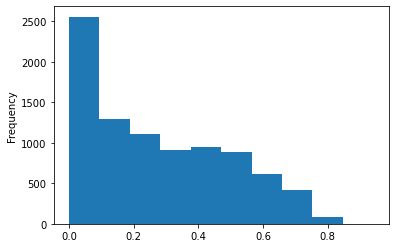

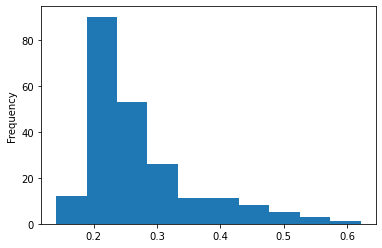

Number of metabolites: 8855
Median fraction of zeros per sample: 0.242.
Median fraction of zeros feature: 0.236


In [11]:
sparsity_per_feature = data_profiling_tools.get_spartsity_plot(metab_raw_data)
sparsity_per_sample = data_profiling_tools.get_spartsity_plot(metab_raw_data, 1)
print(f"Number of metabolites: {metab_raw.shape[0]}")
# median_zero_number = describe_sparsity(metab_raw).count_zeros.median(axis =0)
print(f"Median fraction of zeros per sample: {round(sparsity_per_sample.median(), 3)}.\n"
      f"Median fraction of zeros feature: {round(sparsity_per_feature.median(), 3)}")

In [12]:
# Create a set of the common column names, representing the common samples that have both metabolomics and 16s
sample_ids = stgn_raw_data.index.intersection(metab_raw_data.index)
print(f'Mutual set of samples is of size: {len(sample_ids)}')



Mutual set of samples is of size: 220


### Create dataframes for working only with samples that have both species and metabolomics

In [13]:
# Create dataframes with common sample rows for downstream analysis

mbdf = metab_raw_data.loc[sample_ids,:]
stgndf = stgn_raw_data.loc[sample_ids,:]

N_stgn = stgndf.shape[1] # Num of species
N_metab = mbdf.shape[1] # Num of metabolites
N_samples = len(sample_ids) # Num of samples

print(f"Final raw data shape:\n"
      f"Number of species: {N_stgn}\nNumber of Metabolites: {N_metab}\nNumber of samples (mixed cohorts): {N_samples}")

Final raw data shape:
Number of species: 201
Number of Metabolites: 8847
Number of samples (mixed cohorts): 220


## Separtion of DeepLife and PRISM cohorts
Since the data actually comes from three different cohorts we split it accordingly and analyze each split seperately.  
Cohorts are: **PRISM** (discovery cohort in original paper) and **LifeLines**, **NLIBD** (Validation cohorts).

In [14]:
mbdf_NLIBD, mbdf_LL, mbdf_PRISM  = mbdf.filter(regex='UMCGIBD*', axis = 0), mbdf.filter(regex='LLDeep*', axis = 0), mbdf.filter(regex='PRISM*', axis = 0)
stgndf_NLIBD, stgndf_LL, stgndf_PRISM  = stgndf.filter(regex='UMCGIBD*', axis = 0), stgndf.filter(regex='LLDeep*', axis = 0), stgndf.filter(regex='PRISM*', axis = 0)


### Describe sparsity of each shotgun/metabolite cohort sperately

Since we separte the cohort into 3 and some species only in a specific cohort an artificial sparsity is introduced.  
We therefore must clean it by removing species/metabolites that are a 100% abest.

#### Shotgun data

In [15]:
reload(data_profiling_tools)

<module 'data_profiling_tools' from '/Users/d_private/PycharmProjects/mat_imputation_demo/data_profiling_tools.py'>

Reduced columns sparsity below 1.0, by removing 6 columns.
Reduced columns sparsity below 1.0, by removing 86 columns.
Reduced columns sparsity below 1.0, by removing 87 columns.


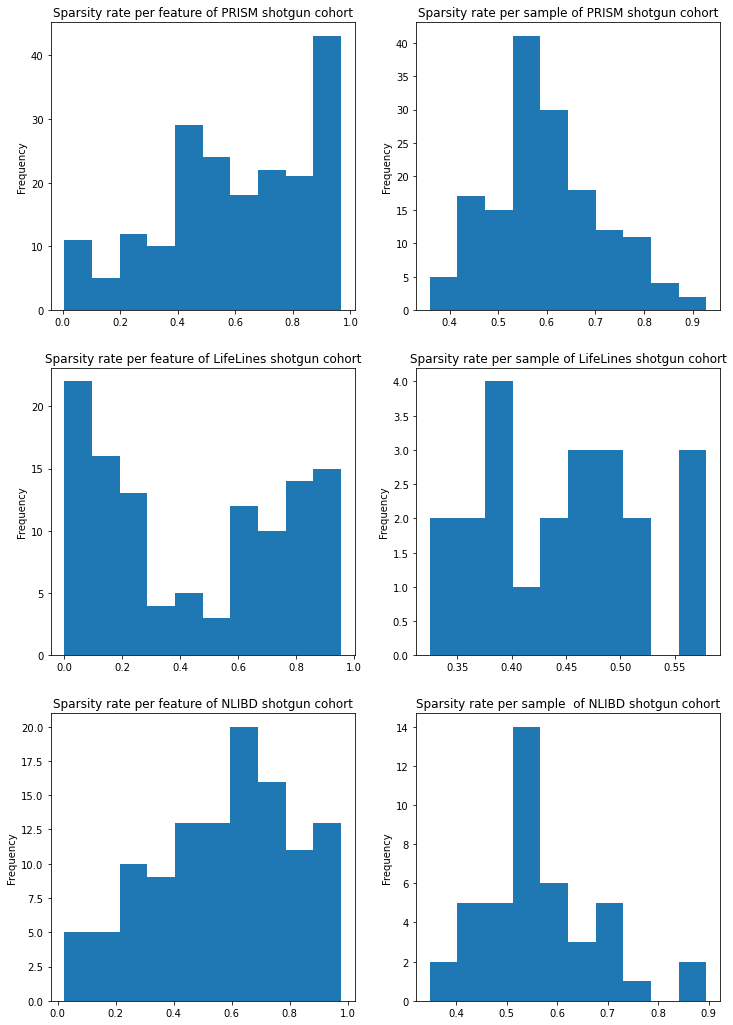

In [16]:
# fig, (ax1, ax2, ax3, ax) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))
fig, ax = plt.subplots(nrows=3, ncols= 2,figsize=(12,18))

# Remoal of zeros that arise from the separation of datasets
stgndf_PRISM = preprocess_tools.reduce_sparsity_below_thr(stgndf_PRISM,  1.0) 
stgndf_NLIBD = preprocess_tools.reduce_sparsity_below_thr(stgndf_NLIBD,  1.0) 
stgndf_LL = preprocess_tools.reduce_sparsity_below_thr(stgndf_LL,  1.0) 

# Plot sparsity per feature/Sample of new datasets
# PRISM
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM, should_plot=False)
zeros.plot(kind='hist', ax=ax[0][0])
ax[0][0].set_title('Sparsity rate per feature of PRISM shotgun cohort')

zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM, _ax=1 ,should_plot=False)
zeros.plot(kind='hist', ax=ax[0][1])
ax[0][1].set_title('Sparsity rate per sample of PRISM shotgun cohort')

#LifeLines
zeros = data_profiling_tools.get_spartsity_plot(stgndf_LL, should_plot=False)
zeros.plot(kind='hist', ax=ax[1][0])
ax[1][0].set_title('Sparsity rate per feature of LifeLines shotgun cohort')

zeros = data_profiling_tools.get_spartsity_plot(stgndf_LL, _ax=1, should_plot=False)
zeros.plot(kind='hist', ax=ax[1][1])
ax[1][1].set_title('Sparsity rate per sample of LifeLines shotgun cohort')

#NLIBD
zeros = data_profiling_tools.get_spartsity_plot(stgndf_NLIBD, should_plot=False)
zeros.plot(kind='hist', ax=ax[2][0])
ax[2][0].set_title('Sparsity rate per feature of NLIBD shotgun cohort')

zeros = data_profiling_tools.get_spartsity_plot(stgndf_NLIBD, _ax=1, should_plot=False)
zeros.plot(kind='hist', ax=ax[2][1])
ax[2][1].set_title('Sparsity rate per sample  of NLIBD shotgun cohort')
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))

plt.show()




### Metabolomics data


Reduced columns sparsity below 1.0, by removing 0 columns.
Reduced columns sparsity below 1.0, by removing 0 columns.
Reduced columns sparsity below 1.0, by removing 0 columns.


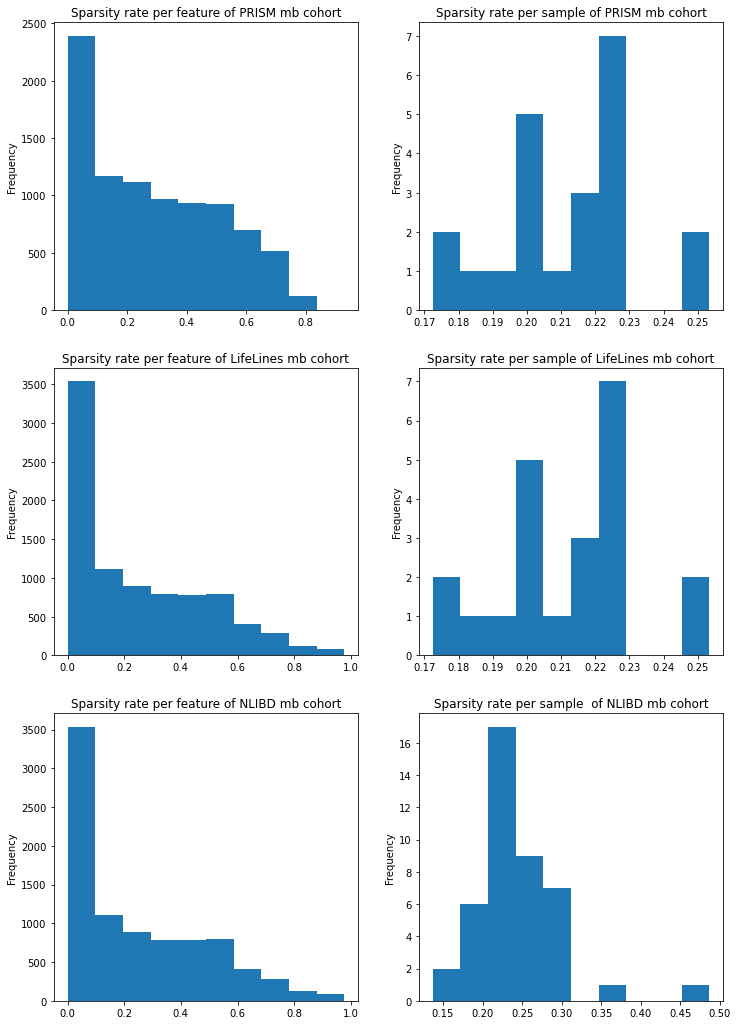

In [22]:
# fig, (ax1, ax2, ax3, ax) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))
fig, ax = plt.subplots(nrows=3, ncols= 2,figsize=(12,18))

# Remoal of zeros that arise from the separation of datasets
mbdf_PRISM = preprocess_tools.reduce_sparsity_below_thr(mbdf_PRISM,  1.0) 
mbdf_NLIBD = preprocess_tools.reduce_sparsity_below_thr(mbdf_NLIBD,  1.0) 
mbdf_LL = preprocess_tools.reduce_sparsity_below_thr(mbdf_LL,  1.0) 

# Plot sparsity per feature/Sample of new datasets
# PRISM
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM, should_plot=False)
zeros.plot(kind='hist', ax=ax[0][0])
ax[0][0].set_title('Sparsity rate per feature of PRISM mb cohort')

zeros = data_profiling_tools.get_spartsity_plot(mbdf_LL, _ax=1 ,should_plot=False)
zeros.plot(kind='hist', ax=ax[0][1])
ax[0][1].set_title('Sparsity rate per sample of PRISM mb cohort')

#LifeLines
zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)
zeros.plot(kind='hist', ax=ax[1][0])
ax[1][0].set_title('Sparsity rate per feature of LifeLines mb cohort')

zeros = data_profiling_tools.get_spartsity_plot(mbdf_LL, _ax=1, should_plot=False)
zeros.plot(kind='hist', ax=ax[1][1])
ax[1][1].set_title('Sparsity rate per sample of LifeLines mb cohort')

#NLIBD
zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)
zeros.plot(kind='hist', ax=ax[2][0])
ax[2][0].set_title('Sparsity rate per feature of NLIBD mb cohort')

zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, _ax=1, should_plot=False)
zeros.plot(kind='hist', ax=ax[2][1])
ax[2][1].set_title('Sparsity rate per sample  of NLIBD mb cohort')
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))

plt.show()



### Write the data for further use

In [25]:
import os

stgndf_PRISM.to_csv(f'{out_path}/stgndf_PRISM.csv', index=True, index_label="# Sample / Feature")
stgndf_LL.to_csv(f'{out_path}/stgndf_LL.csv', index=True, index_label="# Sample / Feature")
stgndf_NLIBD.to_csv(f'{out_path}/stgndf_NLIBD.csv',index=True, index_label="# Sample / Feature")
mbdf_PRISM.to_csv(f'{out_path}/mbdf_PRISM.csv', index=True, index_label="# Sample / Feature")
mbdf_LL.to_csv(f'{out_path}/mbdf_LL.csv', index=True, index_label="# Sample / Feature")
mbdf_NLIBD.to_csv(f'{out_path}/mbdf_NLIBD.csv', index=True, index_label="# Sample / Feature")


# Pre-process data

In [26]:
stgndf_PRISM = pd.read_csv(f'{out_path}/stgndf_PRISM.csv', index_col = '# Sample / Feature')
mbdf_PRISM = pd.read_csv(f'{out_path}/mbdf_PRISM.csv', index_col = '# Sample / Feature')

# mbdf_PRISM.head()
# stgndf_PRISM.head()

## Remove extremely sparse samples - PRISM database - Reduce sparsity

### Shotgun data

Reduced columns sparsity below 0.9, by removing 31 columns.


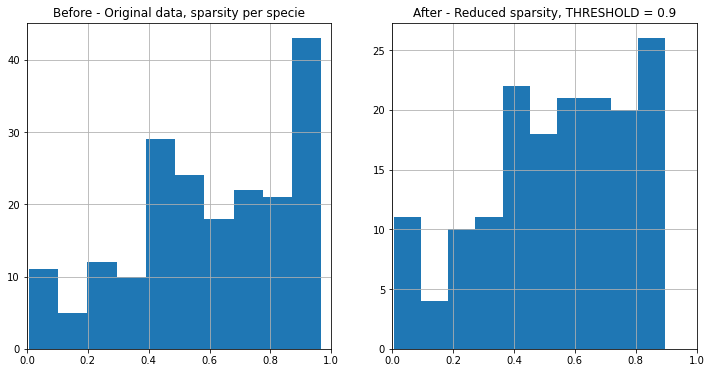

Reduced rows sparsity below 0.9, by removing 1 rows.


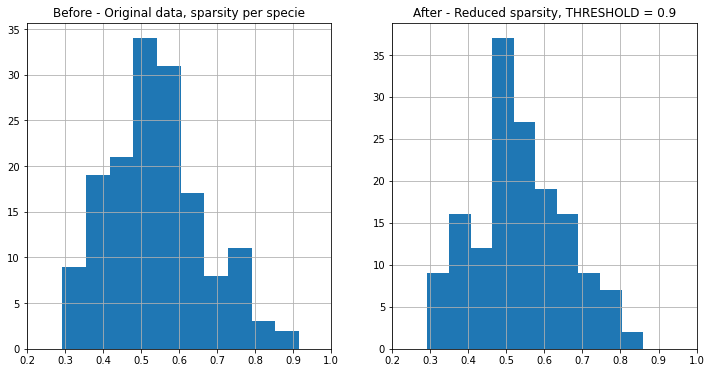

In [18]:
# Remove highly sparse species
SPARSITY_THRESHOLD = .9
    
# Before and after
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

ax1.set_xlim([0,1])
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM, should_plot=False)
zeros.hist(ax=ax1, )
ax1.set_title(f"Before - Original data, sparsity per specie")

stgndf_PRISM_reduced_sparse = preprocess_tools.reduce_sparsity_below_thr(stgndf_PRISM, SPARSITY_THRESHOLD) 
# zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)


ax2.set_xlim([0,1])
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM_reduced_sparse, should_plot=False)
zeros.hist(ax=ax2, )
ax2.set_title(f'After - Reduced sparsity, THRESHOLD = {SPARSITY_THRESHOLD}')
plt.show()


# Repeat the same process to remove highly sparse samples
SPARSITY_THRESHOLD = .9


# Before and after
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

ax1.set_xlim([.2,1])
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM_reduced_sparse, _ax = 1, should_plot=False)
zeros.hist(ax=ax1, )
ax1.set_title(f"Before - Original data, sparsity per specie")


stgndf_PRISM_reduced_sparse = preprocess_tools.reduce_sparsity_below_thr(stgndf_PRISM_reduced_sparse, SPARSITY_THRESHOLD, _ax=1) 
# zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)


ax2.set_xlim([.2,1])
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM_reduced_sparse, _ax = 1, should_plot=False)
zeros.hist(ax=ax2, )
ax2.set_title(f'After - Reduced sparsity, THRESHOLD = {SPARSITY_THRESHOLD}')
plt.show()


### Metabolomics data

Reduced columns sparsity below 0.9, by removing 1 columns.


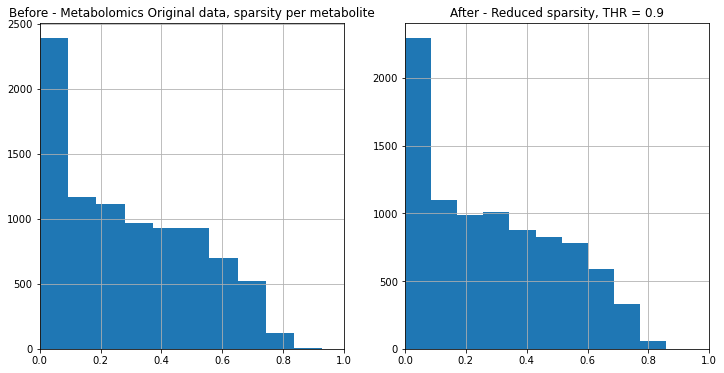

Reduced rows sparsity below 0.9, by removing 0 rows.


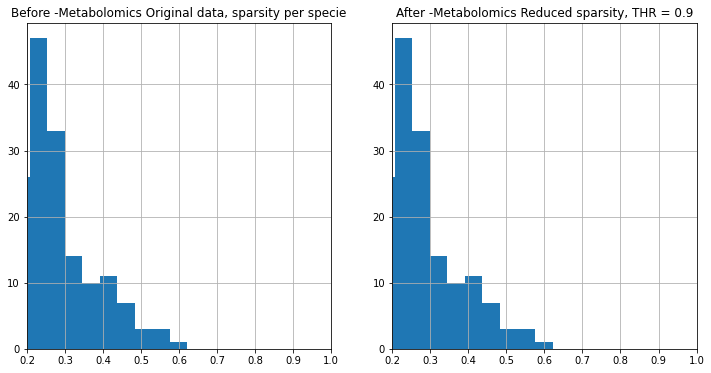

In [19]:
# Remove highly sparse species
SPARSITY_THRESHOLD = .9
    
# Before and after
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

ax1.set_xlim([0,1])
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM, should_plot=False)
zeros.hist(ax=ax1, )
ax1.set_title(f"Before - Metabolomics Original data, sparsity per metabolite")

mbdf_PRISM_reduced_sparse = preprocess_tools.reduce_sparsity_below_thr(mbdf_PRISM, SPARSITY_THRESHOLD) 
# zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)


ax2.set_xlim([0,1])
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM_reduced_sparse, should_plot=False)
zeros.hist(ax=ax2, )
ax2.set_title(f'After - Reduced sparsity, THR = {SPARSITY_THRESHOLD}')
plt.show()


# Repeat the same process to remove highly sparse samples
SPARSITY_THRESHOLD = .9


# Before and after
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

ax1.set_xlim([.2,1])
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM_reduced_sparse, _ax = 1, should_plot=False)
zeros.hist(ax=ax1, )
ax1.set_title(f"Before -Metabolomics Original data, sparsity per specie")


mbdf_PRISM_reduced_sparse = preprocess_tools.reduce_sparsity_below_thr(mbdf_PRISM_reduced_sparse, SPARSITY_THRESHOLD, _ax=1) 
# zeros = data_profiling_tools.get_spartsity_plot(mbdf_NLIBD, should_plot=False)


ax2.set_xlim([.2,1])
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM_reduced_sparse, _ax = 1, should_plot=False)
zeros.hist(ax=ax2, )
ax2.set_title(f'After -Metabolomics Reduced sparsity, THR = {SPARSITY_THRESHOLD}')
plt.show()


## Write reduced sparse dataframes for further use

In [27]:
stgndf_PRISM_reduced_sparse.to_csv(f'{out_path}/stgndf_PRISM_reduced_sparse.csv', index=True, index_label="# Sample / Feature")
mbdf_PRISM_reduced_sparse.to_csv(f'{out_path}/mbdf_PRISM_reduced_sparse.csv', index=True, index_label="# Sample / Feature")


# TODO - preprocess other cohorts as well